News Dataset:
                                                 Link  \
0  https://edition.cnn.com/2023/09/29/business/st...   
1  https://www.channelnewsasia.com/singapore/su-w...   
2  https://edition.cnn.com/2023/05/22/tech/meta-f...   
3  https://www.channelnewsasia.com/singapore/bill...   
4  https://edition.cnn.com/2024/03/05/politics/li...   

                                                Text  content_length language  \
0  Starbucks violated federal labor law when it i...             680       en   
1  The first suspect to plead guilty in Singapore...             740       en   
2  Meta has been fined a record-breaking €1.2 bil...             891       en   
3  SINGAPORE: A 45-year-old man linked to Singapo...             602       en   
4  The Department of Education imposed a record $...             850       en   

   valid_format  accessible  \
0          True         NaN   
1          True         NaN   
2          True         NaN   
3          True         NaN   
4     

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


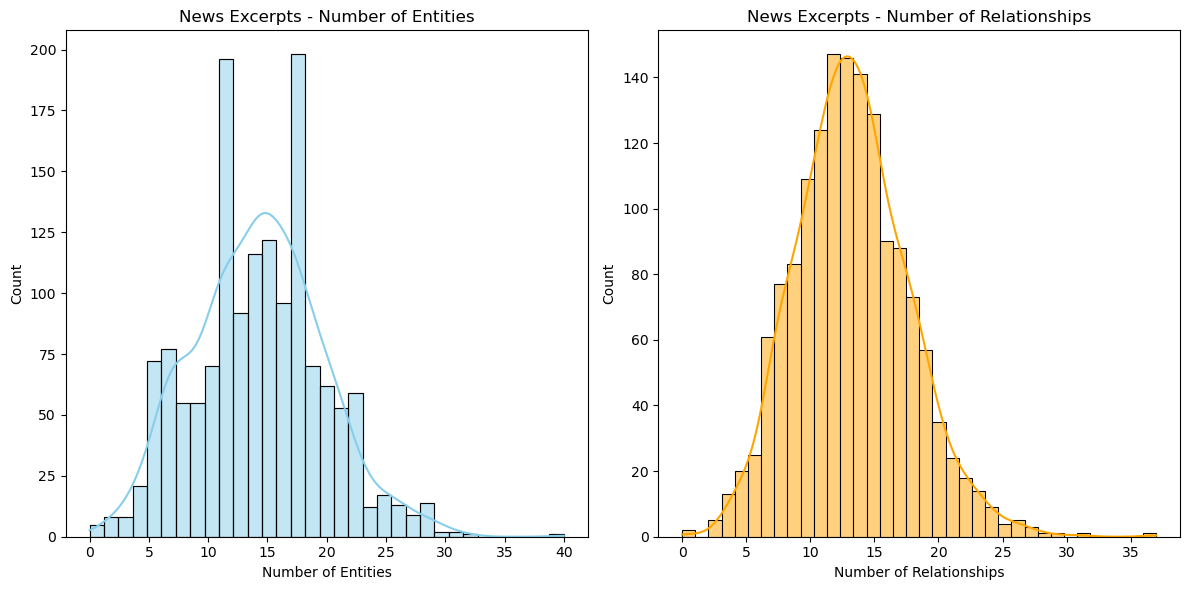

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


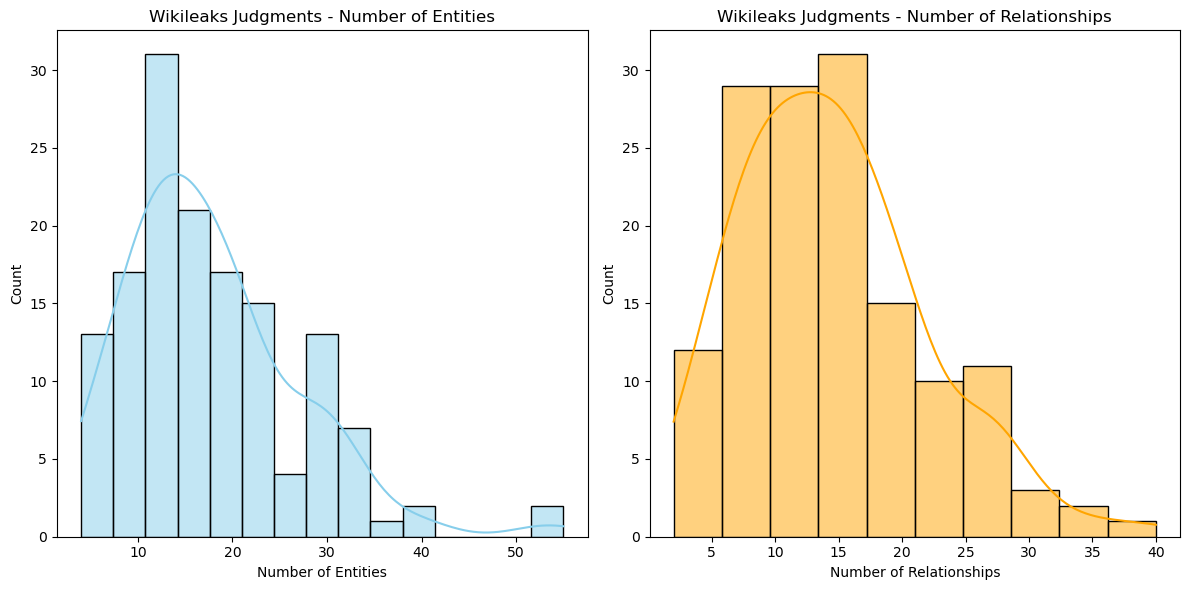

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the datasets
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Data overview
print("News Dataset:\n", news_df.head())
print("Wikileaks Dataset:\n", wikileaks_df.head())

# Summarize the number of entities and relationships
def summarize_data(df, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df['num_entities'], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"{title} - Number of Entities")
    axes[0].set_xlabel("Number of Entities")
    
    sns.histplot(df['num_relationships'], kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"{title} - Number of Relationships")
    axes[1].set_xlabel("Number of Relationships")
    
    plt.tight_layout()
    plt.show()

summarize_data(news_df, "News Excerpts")
summarize_data(wikileaks_df, "Wikileaks Judgments")




For News Excerpt:
1. Number of Entities 
    - This is a bimodal distribution, with two peaks around 10-15 and 18-20 entities, suggesting that news excerpts tend to have few instances with very low or high number of entities. 
    - The presence of peaks might indiciate different types of news excerpts - some dealing with few entities (which might indiciate local news that focus on few key figures), and others with more (which might indicate international or more complex topics)
2. Number of Relationships
    - Histogram follows a normal distribution, where most excerpts have an average number of relationships (around 10-15), suggesting that relationships between entities are more evenly distributed than the number of entities


For Wikileaks:
1. Number of Entities
    - Histogram shows a right-skewed distribution, where most Wikileaks pdfs have a moderate number of entities, but some outliers contain a very high number (40-50)
2. Number of Relationships 
    - distribution of relationships is also right-skewed but slightly smoother. While most documents have 10-20 relationships, some contain much higher numbers (30-40)


Insights from comparison, News Excerpts vs Wikileaks:
1. Entities
    - News excerpts generally contain fewer entities, as news articles usually summarise key events and focus on primary figures
    - Wikileaks documents tend to have more entities due to the nature of the leaked documents, which often contain extensive details about multiple individuals, organizstions, and locations
2. Relationships
    - News excerpts tend to have moderate relationships, as news articles often explain simple connections between entities.
    - Wikileaks documents tend to have more complex relationships, which could be due to the often intricate and detailed nature of the leaked content.

News excerpts focus on summarising key points with simpler entities and relationships, while Wikileaks documents delve into detailed, complex connections due to the nature of the leaks.

---

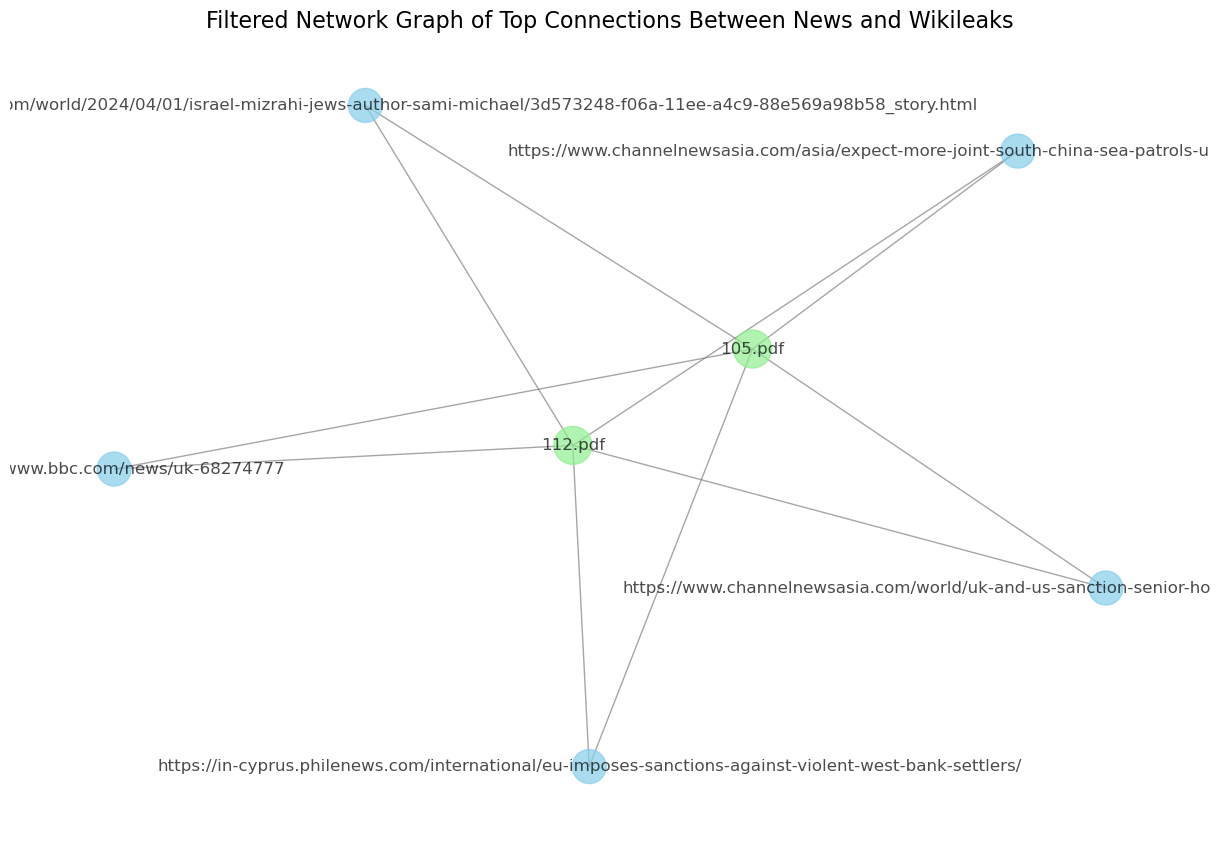

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the Excel files
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Extract entities
news_entities = news_df['entities'].str.split(',').explode()
wikileaks_entities = wikileaks_df['entities'].str.split(',').explode()

# Count most common entities in both datasets
news_entity_counts = Counter(news_entities.dropna())
wikileaks_entity_counts = Counter(wikileaks_entities.dropna())

# Select the top 10 entities from each dataset
common_news_entities = set([entity for entity, _ in news_entity_counts.most_common(10)])
common_wikileaks_entities = set([entity for entity, _ in wikileaks_entity_counts.most_common(10)])

# Filter rows to only include rows with top entities
news_df_filtered = news_df[news_df['entities'].apply(lambda x: any(e in x for e in common_news_entities) if pd.notnull(x) else False)]
wikileaks_df_filtered = wikileaks_df[wikileaks_df['entities'].apply(lambda x: any(e in x for e in common_wikileaks_entities) if pd.notnull(x) else False)]

# Create a graph
G = nx.Graph()

# Add nodes for news articles and Wikileaks judgments
for _, row in news_df_filtered.iterrows():
    G.add_node(row['Link'], type='news')

for _, row in wikileaks_df_filtered.iterrows():
    G.add_node(row['PDF Path'], type='wikileaks')

# Add edges for shared entities with weights
for _, news_row in news_df_filtered.iterrows():
    for _, wiki_row in wikileaks_df_filtered.iterrows():
        news_entities = set(news_row['entities'].split(',')) if pd.notnull(news_row['entities']) else set()
        wiki_entities = set(wiki_row['entities'].split(',')) if pd.notnull(wiki_row['entities']) else set()
        common_entities = news_entities & wiki_entities
        if common_entities:
            G.add_edge(news_row['Link'], wiki_row['PDF Path'], weight=len(common_entities))

# Identify the top 5 weighted edges to create a cleaner graph
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
top_edge_nodes = set([u for u, v, _ in top_edges] + [v for u, v, _ in top_edges])

# Create a subgraph with the top edges
subgraph = G.subgraph(top_edge_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))

# Define node colors based on type
node_colors = ["skyblue" if subgraph.nodes[node]['type'] == 'news' else "lightgreen" for node in subgraph]

# Define node sizes based on degree
node_sizes = [500 + 50 * subgraph.degree[node] for node in subgraph]

# Draw network
pos = nx.spring_layout(subgraph, seed=42)  # Neat layout
nx.draw(
    subgraph, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color="gray", alpha=0.7
)

plt.title("Filtered Network Graph of Top Connections Between News and Wikileaks", fontsize=16)
plt.show()


This network graph visualisations connections between news articles and Wikileaks documents. The green nodes represent Wikileaks files, while the blue nodes represent News Excerpt sources.

Insights:
- The top connections involve 2 Wikileaks documents ("105.pdf" and "112.pdf") being the central hub, connecting multiple news sources
- The topics covered seem to relate to international politics, sanctions, and security issues based on the connected articles
- The variety of news sources indicates widespread interest and coverage of these leaks

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

# Load the data
newsexcerpt_path = "./data/entity_SA_newsexcerpt.xlsx"
wikileaks_path = "./data/entity_SA_wikileaks.xlsx"

df_newsexcerpt = pd.read_excel(newsexcerpt_path)
df_wikileaks = pd.read_excel(wikileaks_path)

# Utility function to parse list-like strings to Python lists
def parse_list_column(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse columns for entities, relationships, and sentiments
df_newsexcerpt['entities'] = parse_list_column(df_newsexcerpt['entities'])
df_newsexcerpt['relationships'] = parse_list_column(df_newsexcerpt['relationships'])
df_newsexcerpt['entity_sentiments'] = parse_list_column(df_newsexcerpt['entity_sentiments'])

df_wikileaks['entities'] = parse_list_column(df_wikileaks['entities'])
df_wikileaks['relationships'] = parse_list_column(df_wikileaks['relationships'])
df_wikileaks['entity_sentiments'] = parse_list_column(df_wikileaks['entity_sentiments'])

# Visualization functions
def visualize_entities(df, title):
    entity_counts = Counter([entity[0] for entities in df['entities'] for entity in entities])
    top_entities = dict(entity_counts.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(top_entities.values()), y=list(top_entities.keys()), palette="viridis")
    plt.title(f"Top 10 Entities - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Entity")
    plt.show()

def visualize_relationships(df, title):
    relationship_counts = Counter([rel[1] for relationships in df['relationships'] for rel in relationships])
    top_relationships = dict(relationship_counts.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(top_relationships.values()), y=list(top_relationships.keys()), palette="coolwarm")
    plt.title(f"Top 10 Relationships - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Relationship")
    plt.show()

def visualize_sentiments(df, title):
    sentiment_counts = Counter([sent['sentiment'] for sentiments in df['entity_sentiments'] for sent in sentiments])

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette="Set2")
    plt.title(f"Sentiment Distribution - {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.show()

def visualize_content_length(df, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['content_length'], bins=20, kde=True, color='purple')
    plt.title(f"Content Length Distribution - {title}")
    plt.xlabel("Content Length")
    plt.ylabel("Frequency")
    plt.show()



Visualizations for entity_SA_newsexcerpt


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


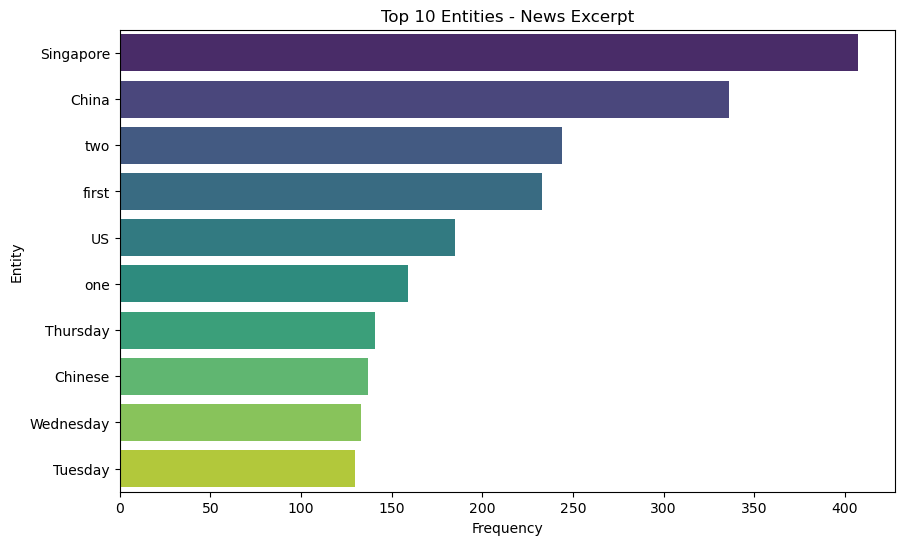

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


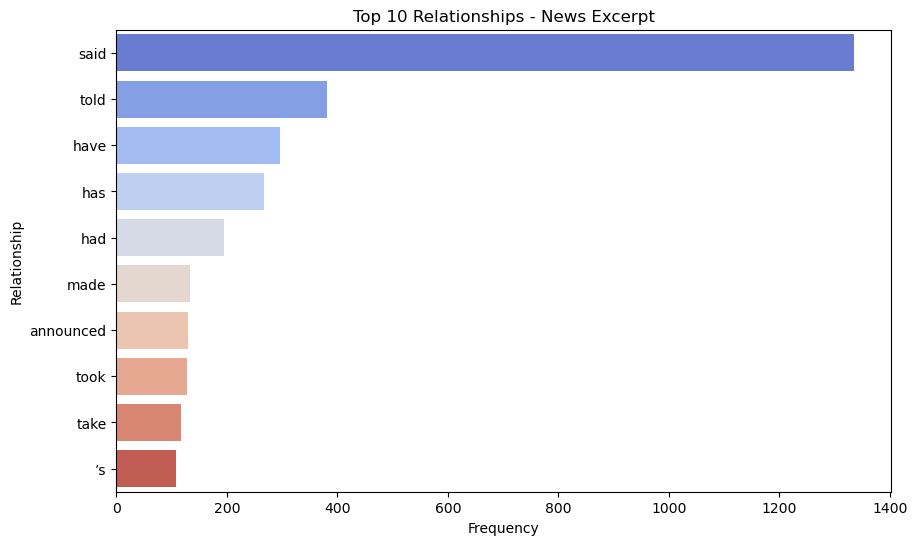

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


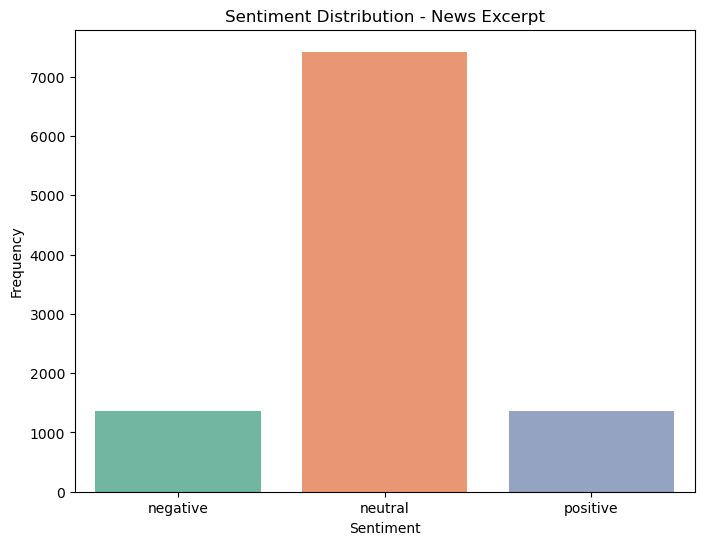

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


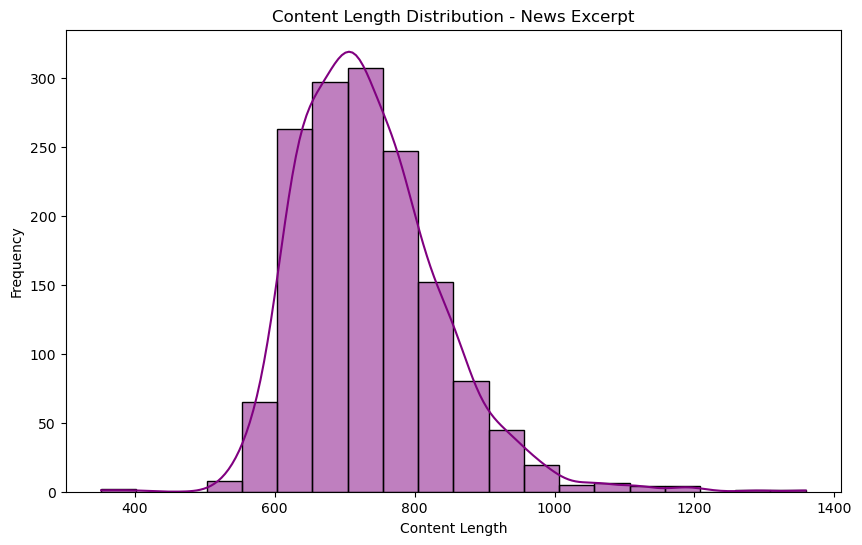

In [2]:
# Visualizations for entity_SA_newsexcerpt
print("Visualizations for entity_SA_newsexcerpt")
visualize_entities(df_newsexcerpt, "News Excerpt")
visualize_relationships(df_newsexcerpt, "News Excerpt")
visualize_sentiments(df_newsexcerpt, "News Excerpt")
visualize_content_length(df_newsexcerpt, "News Excerpt")



Top 10 Entities - News Excerpt
- Singapore and China are the most frequently mentioned entities, indicating that the news excerpt focuses heavily on topics related to these countries.
- Other geopolitical entities like the US and Chinese also appear, suggesting discussions on international affairs
- Words like “two”, “first”, and “one” suggest frequent numerical references, which might be indicating rankings, statistics, or event sequences
- The presence of days of the week (Thursday, Wednesday, Tuesday) implies a timeline-based reporting style, possibly referencing specific events happening on those days

Top 10 Relationships - News Excerpt
- The most frequent relationship word is “said”, indicating a strong emphasis on quotations, statements, or reported speech
- Other words like “told”, “announced”, and “made” further reinforce that the text focuses on communications, official statements, or news reports
- Verbs like “have”, “has”, and “had” suggest descriptions of ongoing and past events, highlighting a mix of present and historical reporting
- The inclusion of “took” and “take” may indicate discussions about actions taken by entities, such as government decisions or corporate moves

These insights suggest that the news excerpt is likely focused on international events, official statements, and political or economic developments involving Singapore, China, and the US.

Sentiment Distribution - News Excerpt
- The majority of the news excerpt has a neutral sentiment (slightly above 7,000), indicating that the content is largely objective or factual rather than opinionated
- There are roughly about the same positive and negative sentiments, showing that while some articles express positivity or negativity, they are less common compared to neutral reporting
    
    --> The relatively balanced presence of positive and negative sentiments might suggest that the news coverage includes both optimistic and critical perspectives on various topics


Content Length Distribution - News Excerpt
- Peak content length is aroud 700 words, meaning most news excerpts fall around this range
- The range of content length (400–1,200 words) suggests a diverse mix of article types, from short-form summarised news to more detailed reports

Visualizations for entity_SA_wikileaks


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


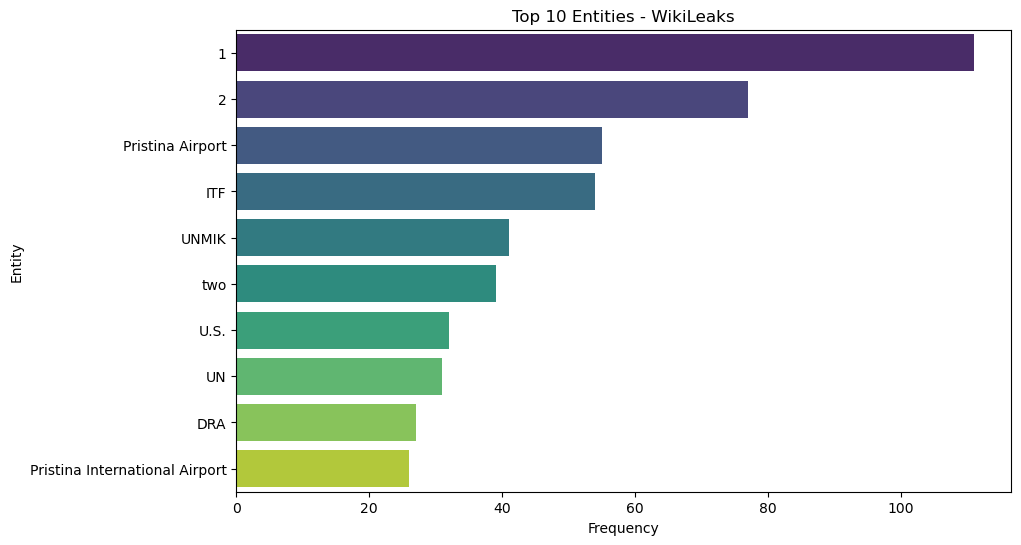

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


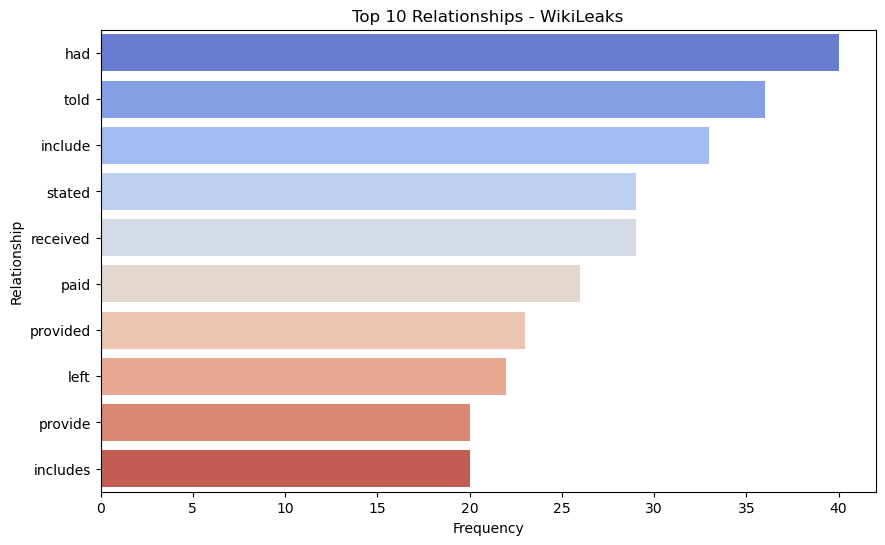

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


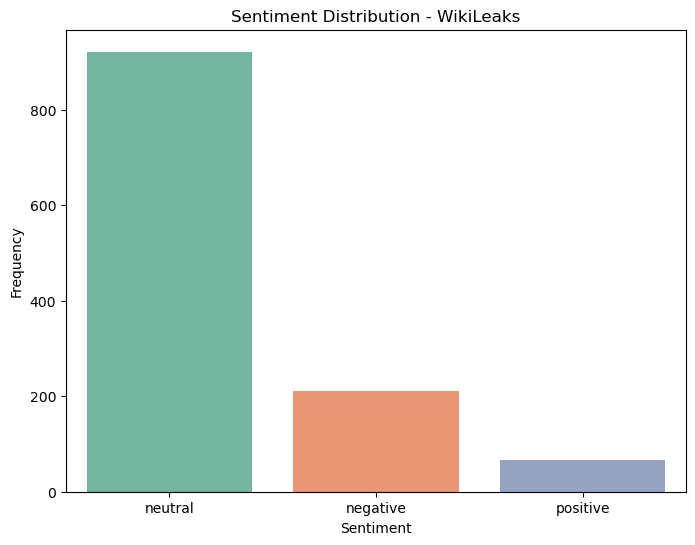

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


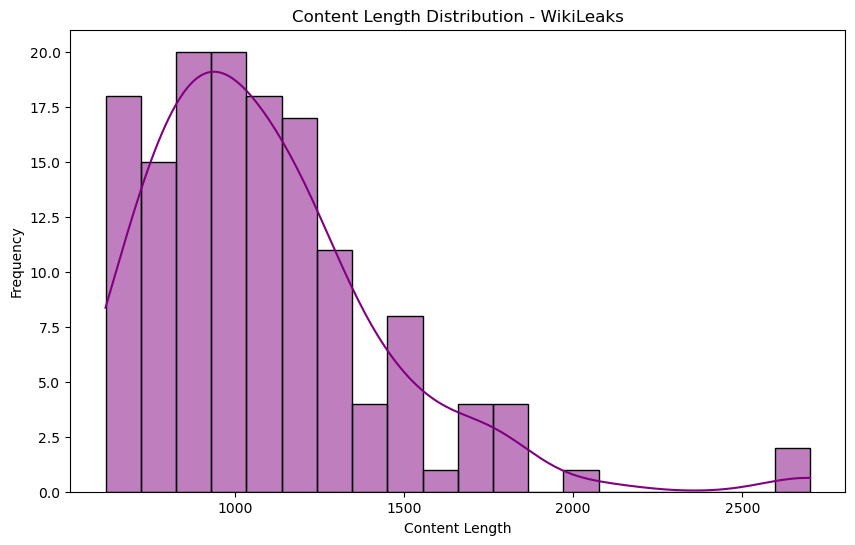

In [3]:
# Visualizations for entity_SA_wikileaks
print("Visualizations for entity_SA_wikileaks")
visualize_entities(df_wikileaks, "WikiLeaks")
visualize_relationships(df_wikileaks, "WikiLeaks")
visualize_sentiments(df_wikileaks, "WikiLeaks")
visualize_content_length(df_wikileaks, "WikiLeaks")


Top 10 Entities - WikiLeaks
- The most frequently mentioned entities include "Pristina Airport," "ITF," and "UNMIK," indicating a focus on geopolitical or infrastructure-related topics
- The presence of "U.S.," "UN," and "DRA" suggests discussions related to international organisations, governance, or military affairs
- The presence of numerical values ("1" and "2") and words like "two" might suggest references to rankings, versions, or sequential events

Top 10 Relationships - WikiLeaks
- The most frequent relationship word is "had" which could imply a strong focus on past events, ownership, or historical context
- Words like "told", "stated", and "received" suggest a mixture of reported speech and transactional interactions, possibly involving diplomatic communications or disclosures
- The verbs "paid", "provided", and "include" hint at financial exchanges, resource distribution, or agreements
- The presence of "left" might suggest discussions around departures, exits, or movement of individuals or organisations

Sentiment Distribution - WikiLeaks
- The majority of the text has a neutral sentiment (around 900), indicating that the content is largely factual or objective.
- Negative sentiment (around 200) is more frequent than positive sentiment (around 100), suggesting a critical or investigative tone, potentially uncovering controversial or sensitive topics.

Content Length Distribution - WikiLeaks
- The most common document length is around 1000 words, indicating that the majority of WikiLeaks content is relatively detailed.
- The range extends up to 2000 words, with an outlier at approximately 2500 words, suggesting that some documents are significantly longer and contain extensive information.

**Comparison: News Excerpt vs. WikiLeaks**  
News excerpts focus on geopolitical events and official statements, with frequent reported speech ("said," "told"). Sentiment is balanced, while WikiLeaks content is mostly neutral but leans more negative due to its investigative nature.  

News articles are shorter (400–1200 words, peaking at 700) for quick consumption, whereas WikiLeaks documents are longer (peaking at 1000, some over 2000), suggesting in-depth reports. While news reports structured events, WikiLeaks content includes more transactional records, governance discussions, and disclosures.

---

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Load the datasets
news_file = "./data/entity_SA_newsexcerpt.xlsx"
wikileaks_file = "./data/entity_SA_wikileaks.xlsx"

df_news = pd.read_excel(news_file)
df_wikileaks = pd.read_excel(wikileaks_file)

# Function to visualize entity frequency
def visualize_entity_frequency(df, title):
    entity_list = []
    for entities in df['entities']:
        if isinstance(entities, str):
            entity_list.extend(eval(entities))

    entity_names = [entity[0] for entity in entity_list]
    entity_counts = pd.Series(entity_names).value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=entity_counts.values, y=entity_counts.index, palette="viridis")
    plt.title(f"Top 10 Entities in {title}")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.show()

# Function to visualize relationship frequency
def visualize_relationship_frequency(df, title):
    relationship_list = []
    for relationships in df['relationships']:
        if isinstance(relationships, str):
            relationship_list.extend(eval(relationships))

    relationship_names = [rel[1] for rel in relationship_list]
    relationship_counts = pd.Series(relationship_names).value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=relationship_counts.values, y=relationship_counts.index, palette="magma")
    plt.title(f"Top 10 Relationships in {title}")
    plt.xlabel("Count")
    plt.ylabel("Relationship")
    plt.show()

# Function to visualize sentiment distribution
def visualize_sentiment_distribution(df, title):
    sentiments = []
    for entity_sentiments in df['entity_sentiments']:
        if isinstance(entity_sentiments, str):
            sentiments.extend([entry['sentiment'] for entry in eval(entity_sentiments)])

    sentiment_counts = pd.Series(sentiments).value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="cool")
    plt.title(f"Sentiment Distribution in {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

# Function to visualize content length distribution
def visualize_content_length(df, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['content_length'], kde=True, color="blue", bins=20)
    plt.title(f"Content Length Distribution in {title}")
    plt.xlabel("Content Length")
    plt.ylabel("Frequency")
    plt.show()

# Function to visualize similarity among rows
def visualize_similarity(df, text_column, title):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[text_column].fillna(""))
    similarity_matrix = cosine_similarity(tfidf_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap="coolwarm", square=True)
    plt.title(f"Row Similarity Heatmap in {title}")
    plt.xlabel("Row Index")
    plt.ylabel("Row Index")
    plt.show()

# Function to visualize combined data insights
def visualize_combined(df1, df2):
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Combined entity frequency
    visualize_entity_frequency(combined_df, "Combined Dataset")

    # Combined sentiment distribution
    visualize_sentiment_distribution(combined_df, "Combined Dataset")

    # Combined content length distribution
    visualize_content_length(combined_df, "Combined Dataset")

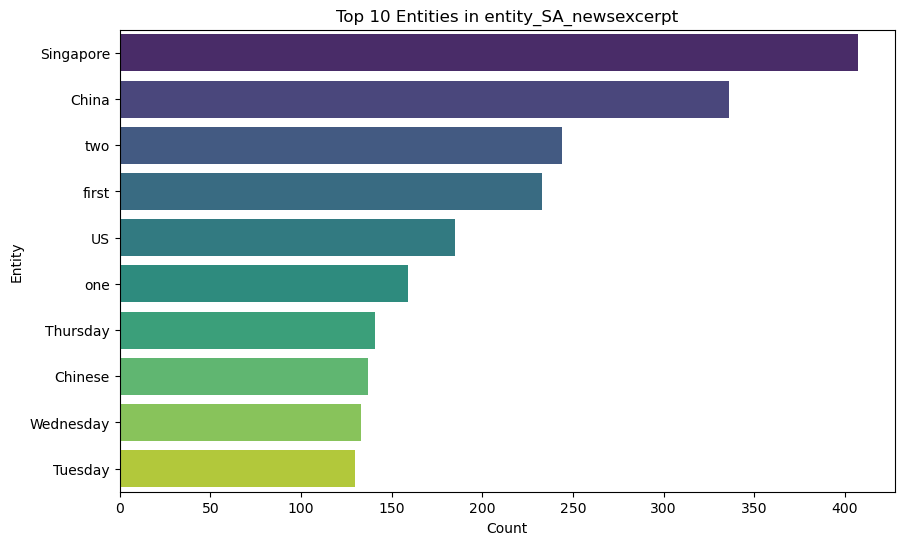

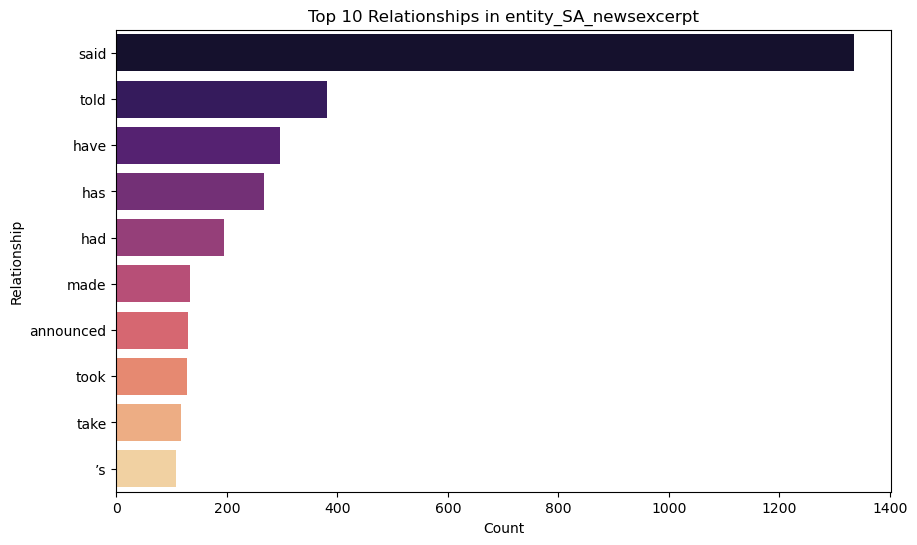

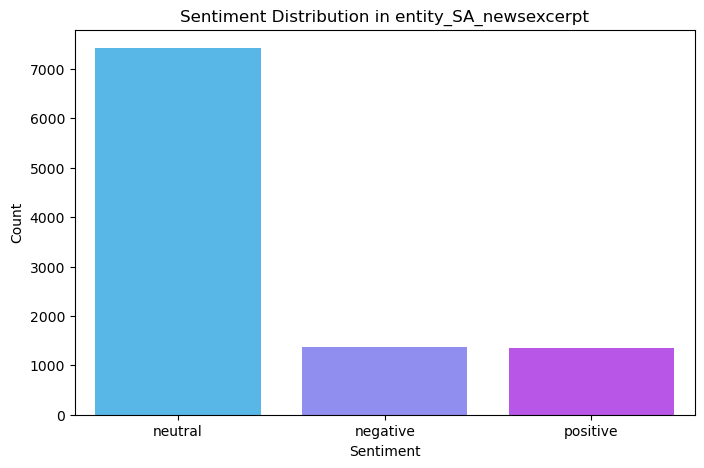

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


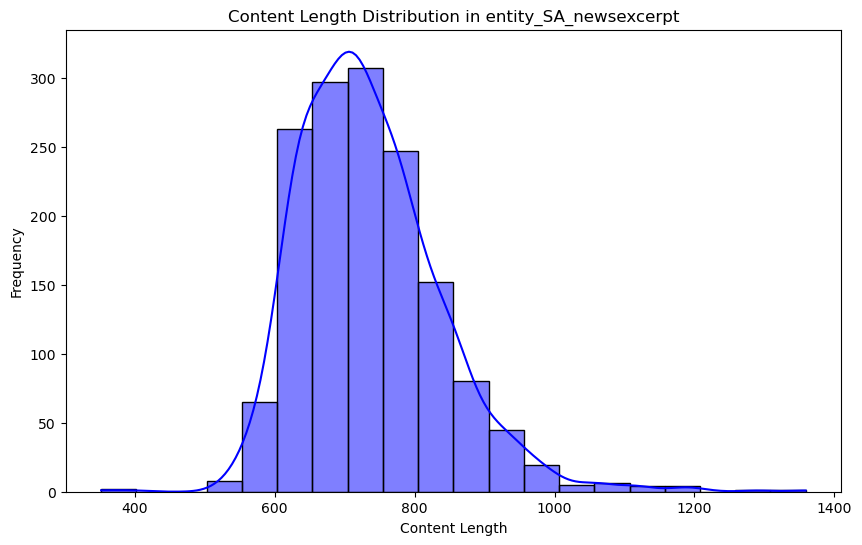

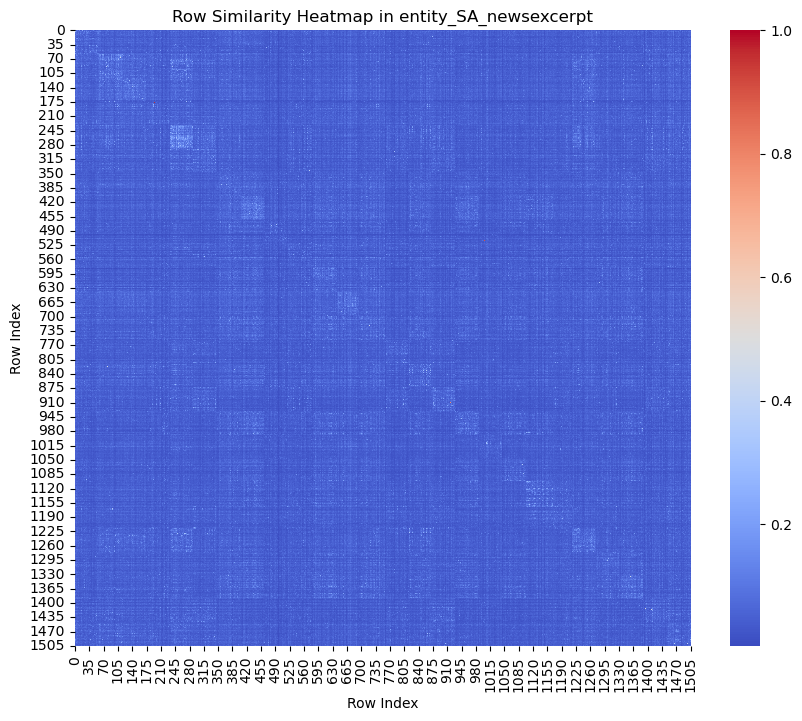

In [6]:
# Visualizations for entity_SA_newsexcerpt
df_news['text'] = df_news['Text']  # Ensure text column consistency
visualize_entity_frequency(df_news, "entity_SA_newsexcerpt")
visualize_relationship_frequency(df_news, "entity_SA_newsexcerpt")
visualize_sentiment_distribution(df_news, "entity_SA_newsexcerpt")
visualize_content_length(df_news, "entity_SA_newsexcerpt")
visualize_similarity(df_news, "text", "entity_SA_newsexcerpt")

Row Similarity Heat Map - News Excerpt:
- Low Overall Similarity: The prevalence of blue indicates that there is generally low similarity between the rows of data

    --> Unique events and stories, where news is about current events. Each story is often unique, focusing on specific individuals, locations, and incidents. This potentially creates a high degree of variability and low similarity between excerpts.

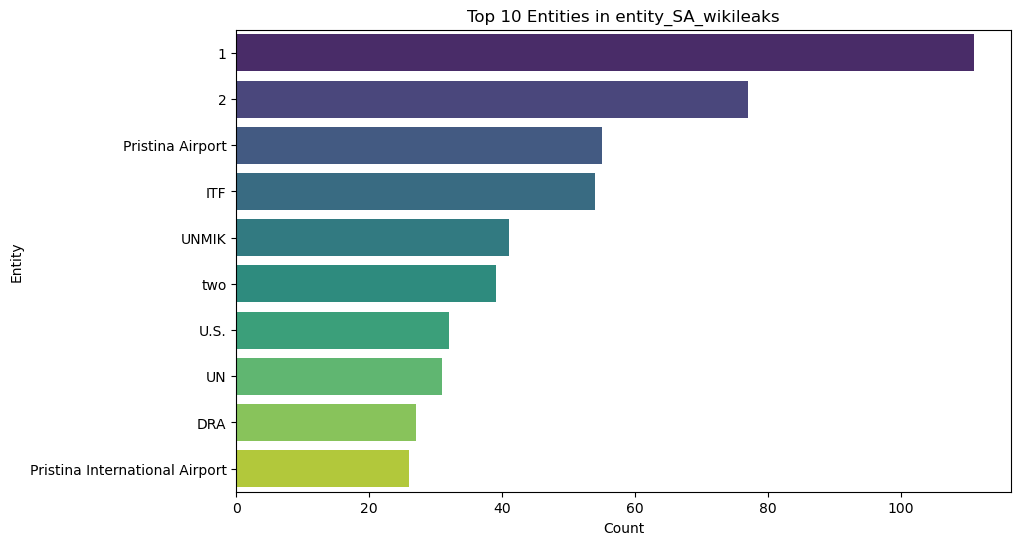

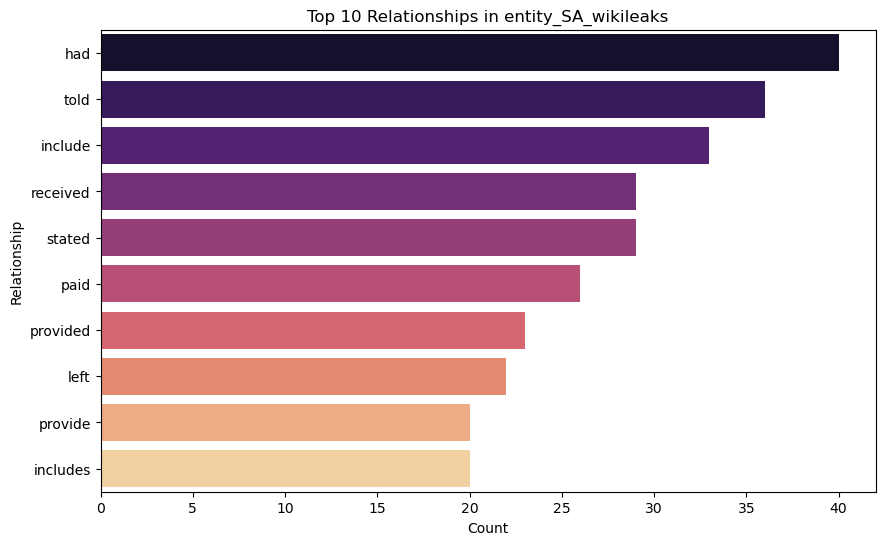

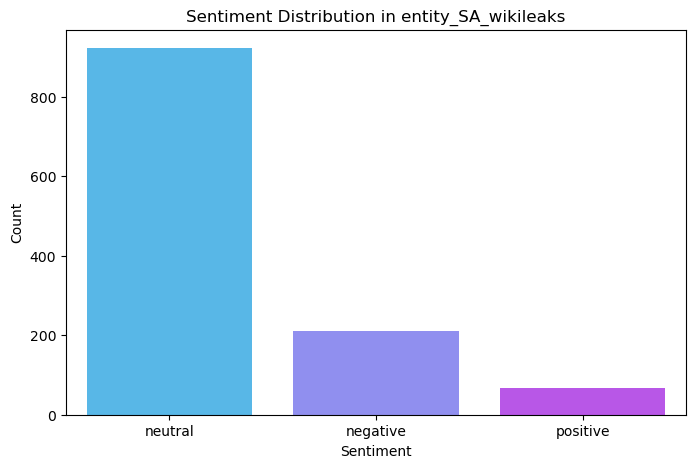

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


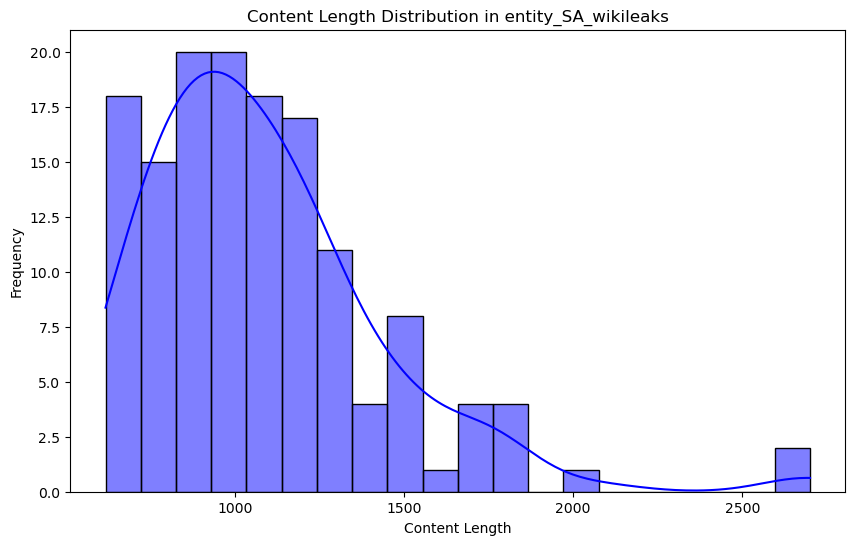

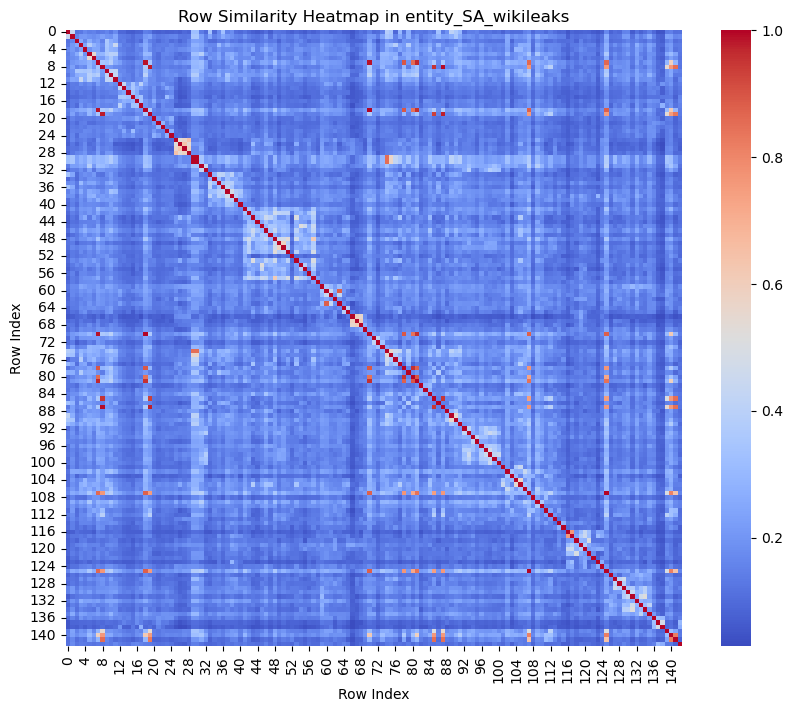

In [7]:
# Visualizations for entity_SA_wikileaks
df_wikileaks['text'] = df_wikileaks['Text']  # Ensure text column consistency
visualize_entity_frequency(df_wikileaks, "entity_SA_wikileaks")
visualize_relationship_frequency(df_wikileaks, "entity_SA_wikileaks")
visualize_sentiment_distribution(df_wikileaks, "entity_SA_wikileaks")
visualize_content_length(df_wikileaks, "entity_SA_wikileaks")
visualize_similarity(df_wikileaks, "text", "entity_SA_wikileaks")


Row Similarity Heat Map - Wikileaks:
- The majority of heatmap of wikileaks is blue, however there are more small clusters of warmer colors as compared to heatmap of news excerpts, indicating groups of rows with higher similarity 

- The diverse nature of Wikileaks releases directly translates to the observed pattern in the heatmap.
    - Red Clusters: These likely represent groups of documents related to specific leaks or events, such as the release of diplomatic cables from a particular country or the publication of intelligence reports on a specific topic
    - Blue Areas: These likely represent documents from entirely different categories of leaks, such as comparing diplomatic cables to leaked corporate documents, which would show low similarity


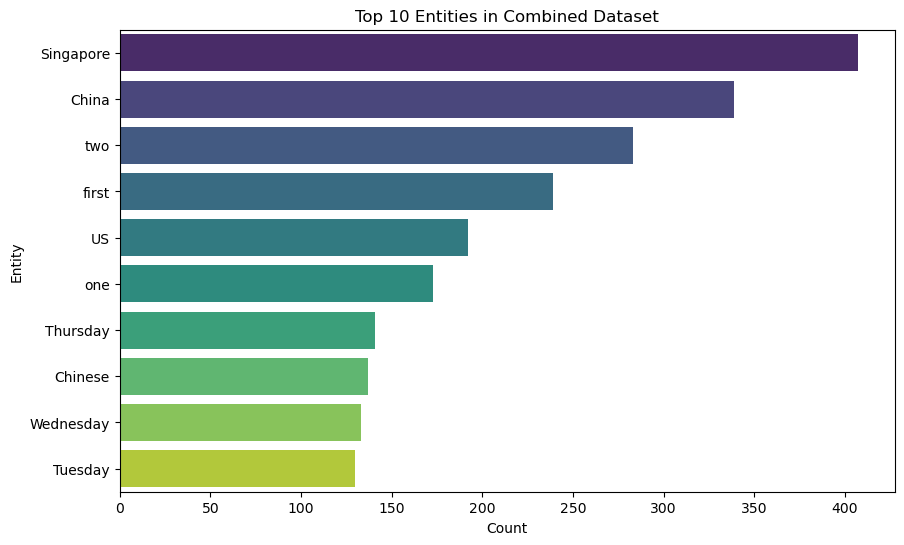

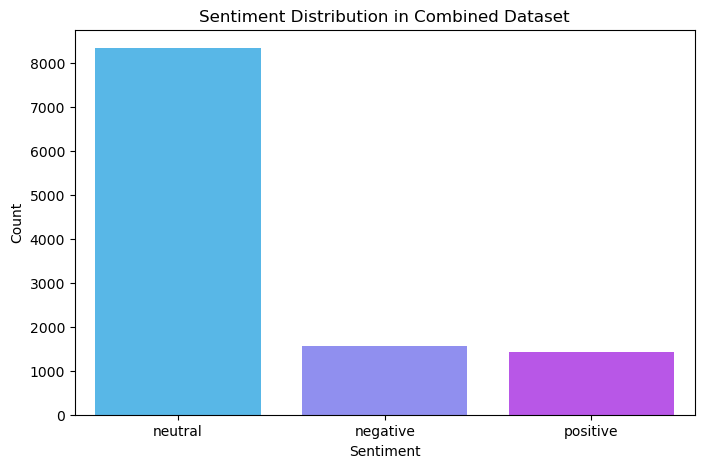

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


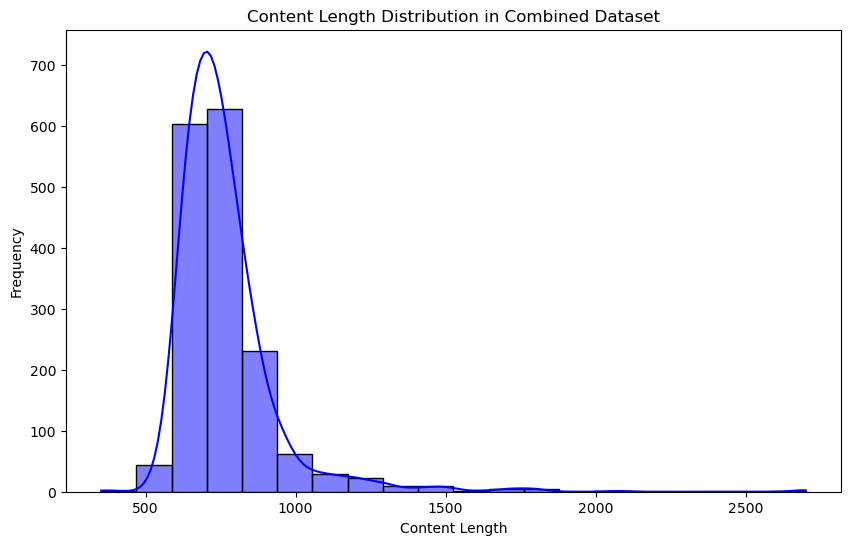

In [8]:
# Combined visualizations
visualize_combined(df_news, df_wikileaks)


# Visualization of Similarity Scores

SentenceBERT Results Sheets: dict_keys(['Sheet1'])
Cited Judgments Sheets: dict_keys(['Sheet1'])

SentenceBERT Results Preview:
          Method                                          news_Link  \
0  Sentence-BERT  https://edition.cnn.com/2023/09/29/business/st...   
1  Sentence-BERT  https://edition.cnn.com/2023/09/29/business/st...   
2  Sentence-BERT  https://edition.cnn.com/2023/09/29/business/st...   
3  Sentence-BERT  https://edition.cnn.com/2023/09/29/business/st...   
4  Sentence-BERT  https://edition.cnn.com/2023/09/29/business/st...   

                                           news_Text  \
0  Starbucks violated federal labor law when it i...   
1  Starbucks violated federal labor law when it i...   
2  Starbucks violated federal labor law when it i...   
3  Starbucks violated federal labor law when it i...   
4  Starbucks violated federal labor law when it i...   

                                       news_entities  \
0  [('National Labor Relations Board', 'ORG'), ('...

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


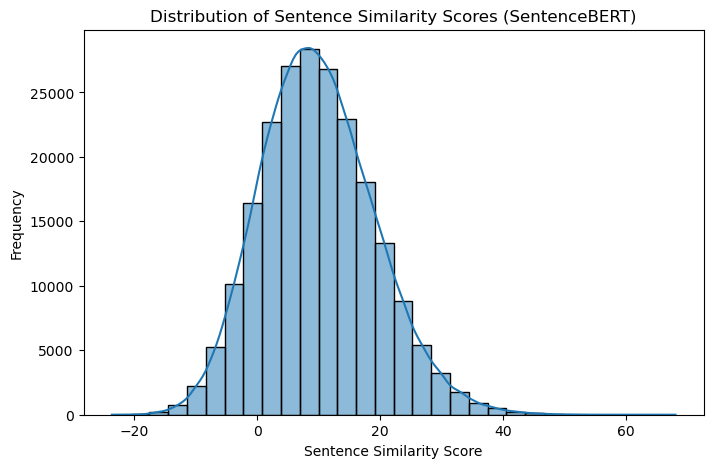

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


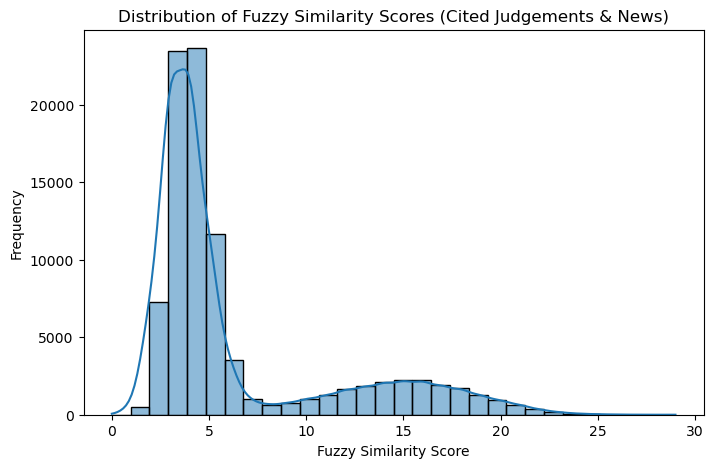

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel files
sentencebert_results_path = "data/sentencebert_results.xlsx"  # Update with correct path
cited_judgments_path = "data/cited_judgments_with_news_articles.xlsx"  # Update with correct path

# Load all sheets
sentencebert_df = pd.read_excel(sentencebert_results_path, None)  # Load all sheets
cited_judgments_df = pd.read_excel(cited_judgments_path, None)  # Load all sheets

# Print available sheet names
print("SentenceBERT Results Sheets:", sentencebert_df.keys())
print("Cited Judgments Sheets:", cited_judgments_df.keys())

# Load main sheets (update names if needed)
sentencebert_main_df = list(sentencebert_df.values())[0]
cited_judgments_main_df = list(cited_judgments_df.values())[0]

# Display first few rows of each dataset
print("\nSentenceBERT Results Preview:")
print(sentencebert_main_df.head())

print("\nCited Judgments Preview:")
print(cited_judgments_main_df.head())

### Visualization for SentenceBERT Results ###
# Assuming there are similarity scores in a column named 'similarity_score'
plt.figure(figsize=(8, 5))
sns.histplot(sentencebert_main_df['content_similarity'], bins=30, kde=True)
plt.xlabel("Sentence Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Similarity Scores (SentenceBERT)")
plt.show()

### Visualization for Cited Judgements with News Articles ###
# Assuming there is a similarity column from fuzzy matching named 'fuzzy_score'
plt.figure(figsize=(8, 5))
sns.histplot(cited_judgments_main_df['content_similarity'], bins=30, kde=True)
plt.xlabel("Fuzzy Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Fuzzy Similarity Scores (Cited Judgements & News)")
plt.show()


Description of SentenceBERT Similarity Scores:
- Distribution: The SentenceBERT similarity scores exhibit a bell-shaped distribution, indicating that most sentence pairs have scores clustered around a central value.
- Central Tendency: The peak of the distribution is around a score of 10, suggesting that many sentence pairs have a similarity score close to this value.
- Spread: The distribution shows a moderate spread, indicating variability in similarity scores between sentence pairs.

Description of Fuzzy Similarity Scores:
- Distribution: The distribution of fuzzy similarity scores is skewed to the right, with a long tail extending towards higher similarity scores. This suggests that a majority of the pairs have relatively low similarity scores, while a smaller number have very high similarity scores.
- Central Tendency: The peak of the distribution appears to be around a score of 4-5, indicating that a large proportion of cited judgements and news pairs have similarity scores within this range.
- Spread: The distribution is relatively wide, indicating a considerable range of similarity scores between the pairs.

Comparison:
- Shape: The SentenceBERT distribution is more symmetrical (bell-shaped) compared to the skewed distribution of fuzzy similarity scores.
- Central Tendency: The SentenceBERT distribution had a higher central tendency, with the peak around a score of 10. This suggests that SentenceBERT might generally assign higher similarity scores compared to the fuzzy similarity metric.
- Spread: The SentenceBERT distribution might have been slightly wider, indicating a greater range of similarity scores.

    --> Possible reasons for differences is due to different Similarity Metrics: The fuzzy similarity metric likely relies on comparing entities, relationships, and potentially keywords. SentenceBERT, on the other hand, leverages a deep learning model trained on massive text data to capture semantic similarity

In [3]:
print(sentencebert_main_df.columns)


Index(['Method', 'news_Link', 'news_Text', 'news_entities',
       'news_relationships', 'news_Category_x', 'news_Category_y',
       'wikileaks_Text', 'wikileaks_entities', 'wikileaks_relationships',
       'wikileaks_Category', 'content_similarity'],
      dtype='object')


In [5]:
print(cited_judgments_main_df.columns)

Index(['news_Link', 'news_Text', 'news_entities', 'news_relationships',
       'news_Category_x', 'news_Category_y', 'wikileaks_Text',
       'wikileaks_entities', 'wikileaks_relationships', 'wikileaks_Category',
       'common_entities', 'common_relationships', 'content_similarity'],
      dtype='object')


# Visualisations of SBert

In [8]:
!pip install wordcloud



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


Available Columns: Index(['Method', 'news_Link', 'news_Text', 'news_entities',
       'news_relationships', 'news_Category_x', 'news_Category_y',
       'wikileaks_Text', 'wikileaks_entities', 'wikileaks_relationships',
       'wikileaks_Category', 'content_similarity'],
      dtype='object')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


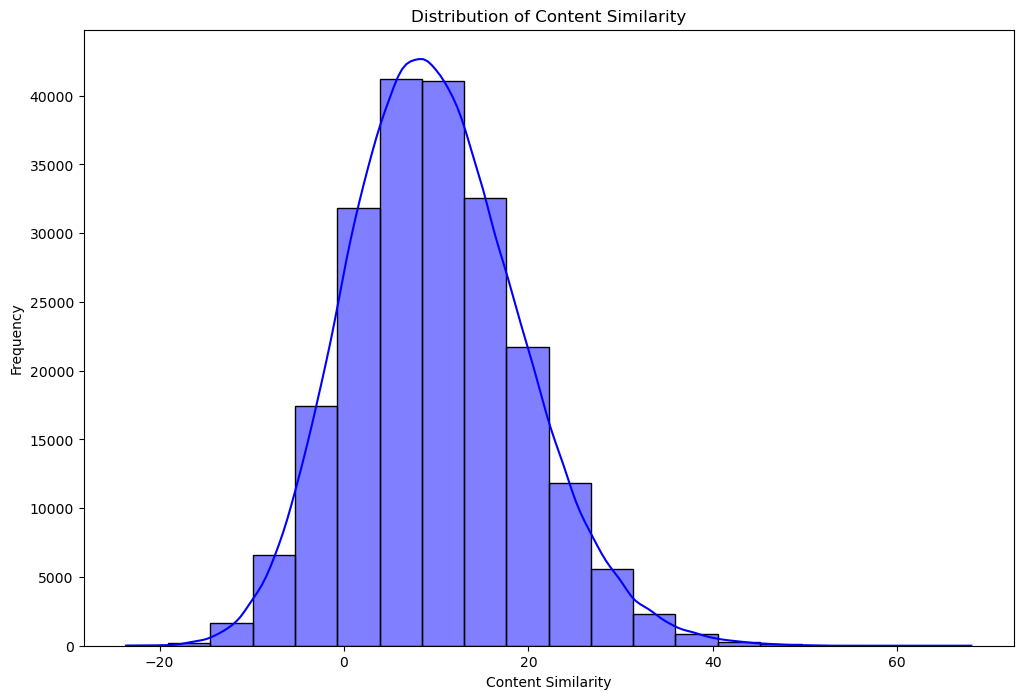

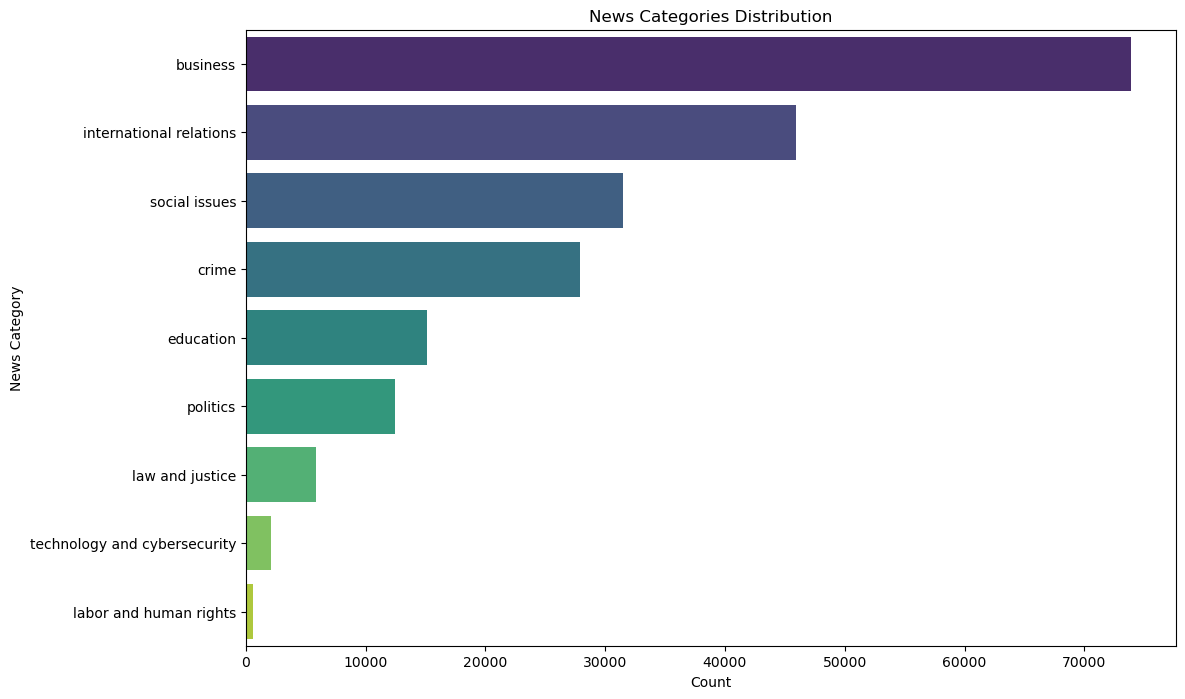

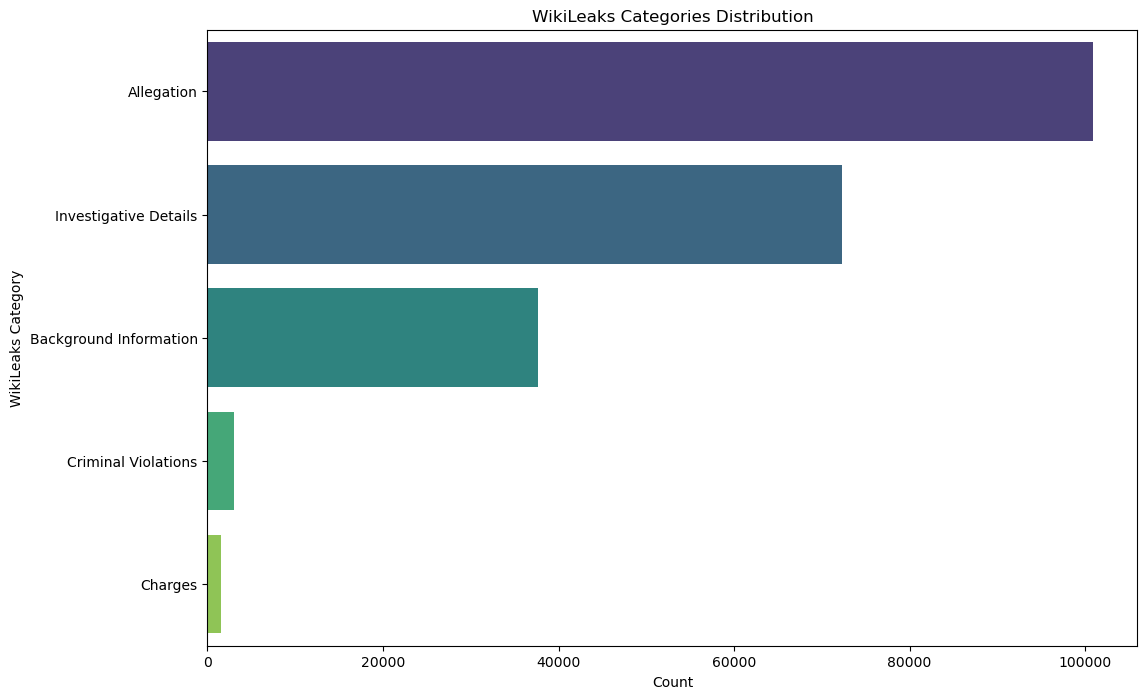

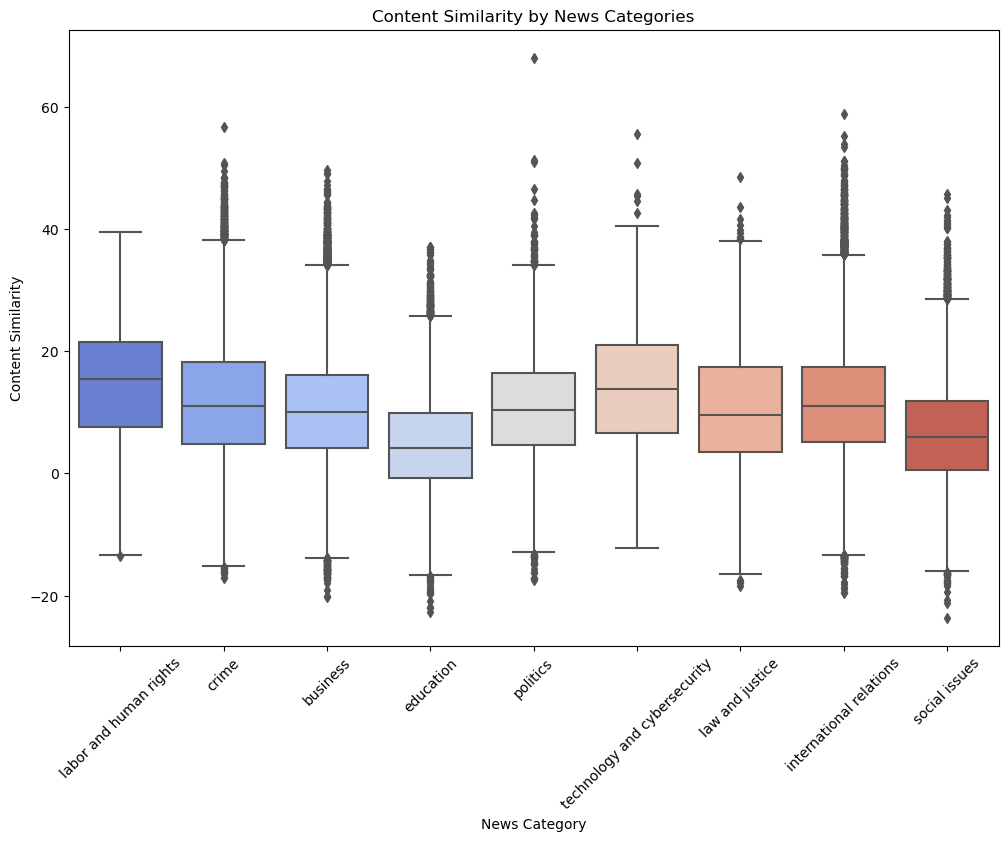

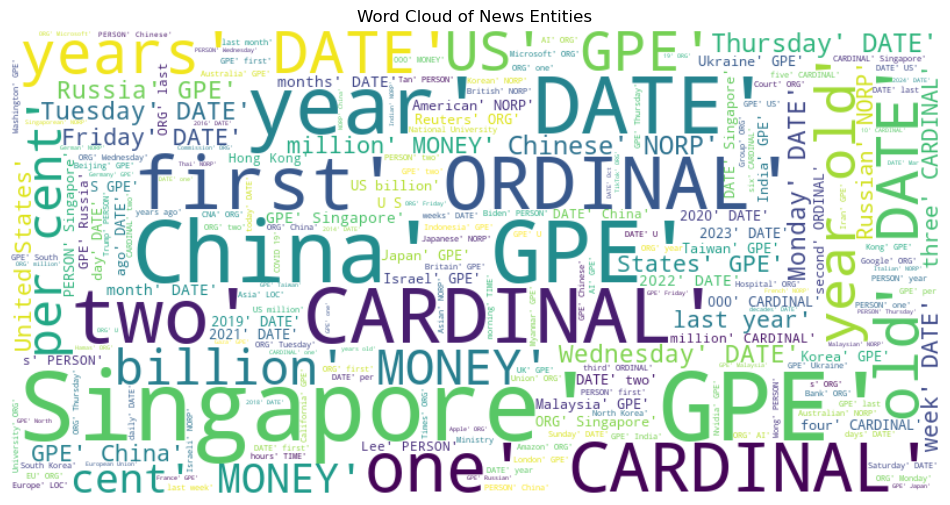

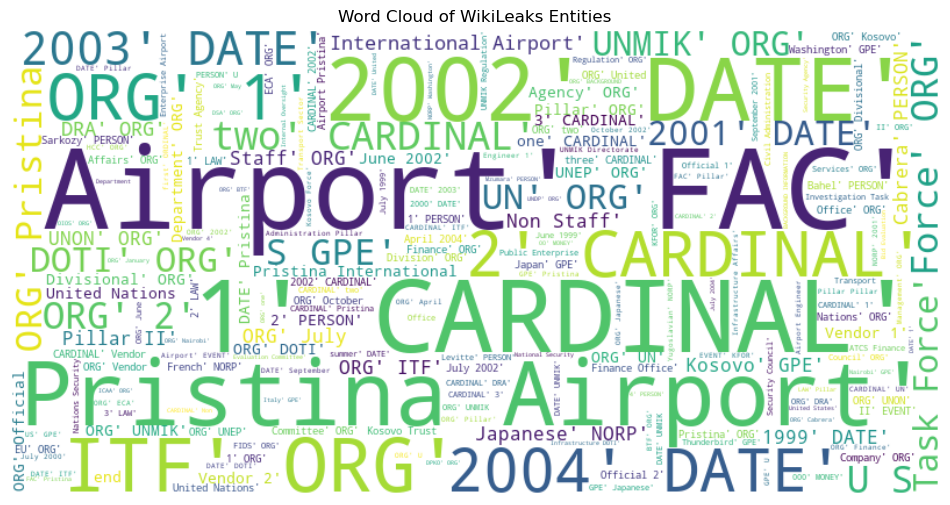

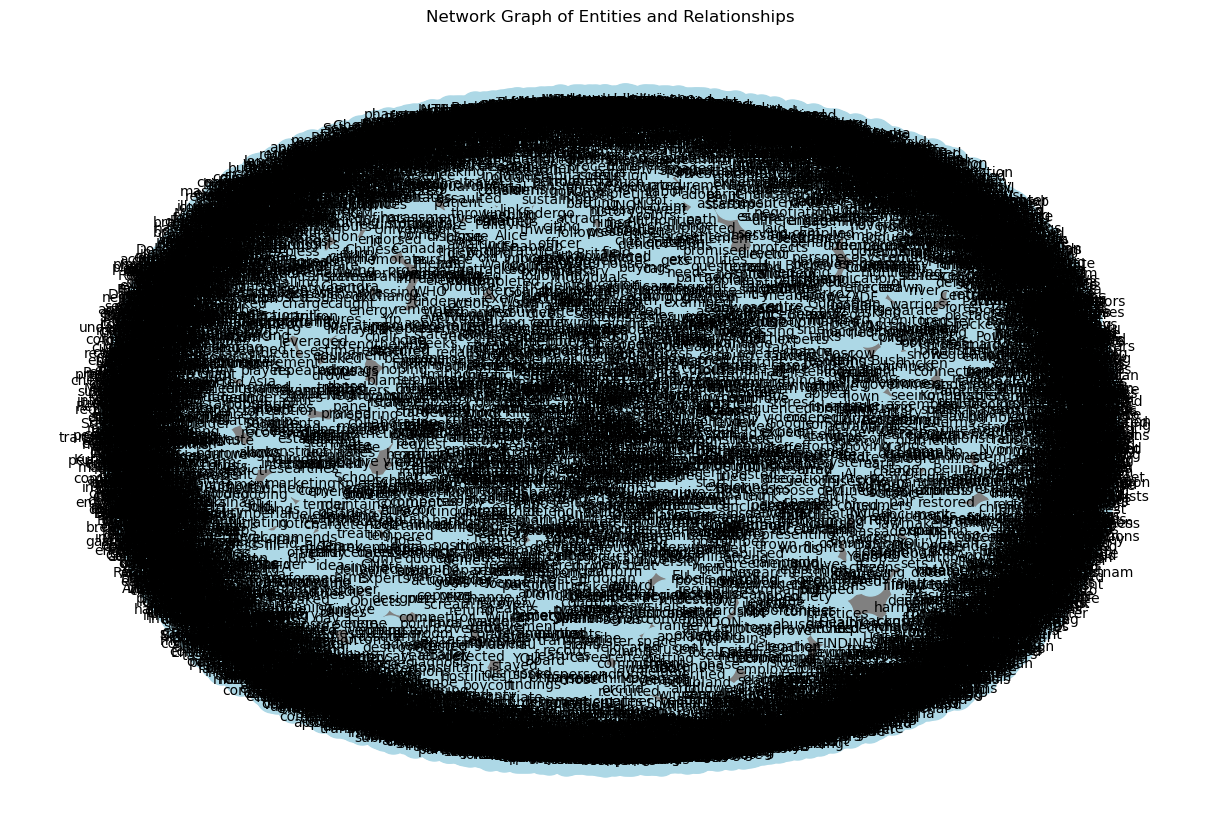

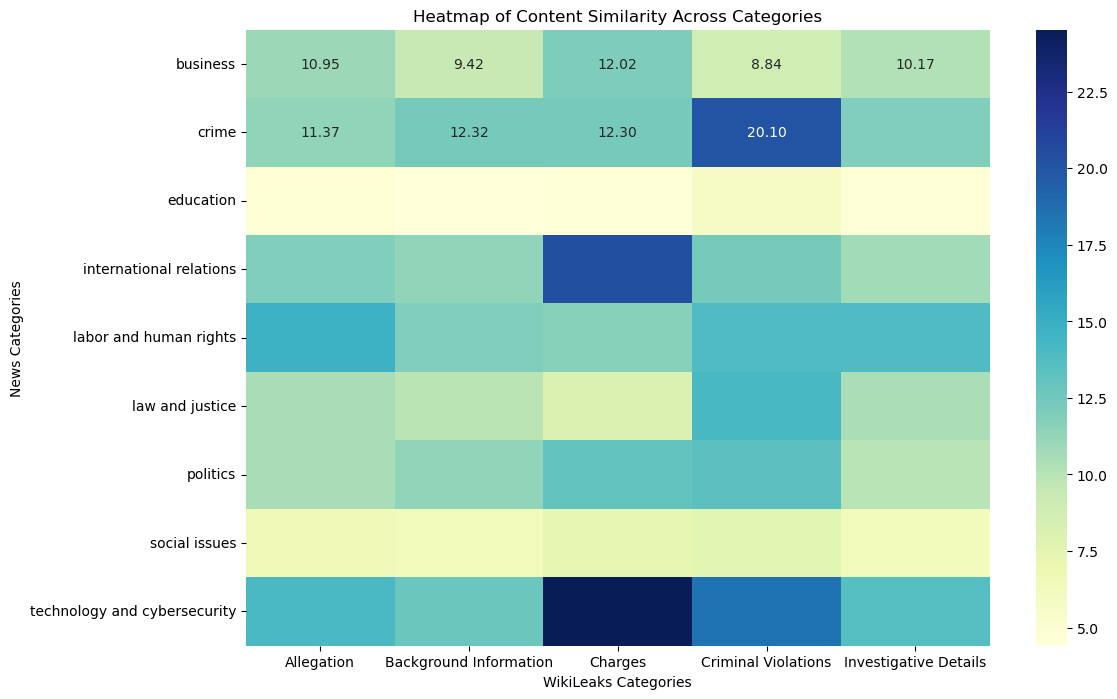

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
import ast  # For safely evaluating string lists

# Load the dataset
file_path = "data/sentencebert_results.xlsx"  # Update with correct path
df = pd.read_excel(file_path)

# Set figure size for better visualizations
plt.rcParams['figure.figsize'] = [12, 8]

# Check available columns
print("Available Columns:", df.columns)

# 1. Distribution of Content Similarity
if 'content_similarity' in df.columns:
    plt.figure()
    sns.histplot(df['content_similarity'], kde=True, bins=20, color='blue')
    plt.title('Distribution of Content Similarity')
    plt.xlabel('Content Similarity')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Column 'content_similarity' not found in dataset.")

# 2. Count of News Categories and WikiLeaks Categories
if 'news_Category_x' in df.columns:
    plt.figure()
    sns.countplot(y=df['news_Category_x'], order=df['news_Category_x'].value_counts().index, palette="viridis")
    plt.title('News Categories Distribution')
    plt.xlabel('Count')
    plt.ylabel('News Category')
    plt.show()
else:
    print("Column 'news_Category_x' not found in dataset.")

if 'wikileaks_Category' in df.columns:
    plt.figure()
    sns.countplot(y=df['wikileaks_Category'], order=df['wikileaks_Category'].value_counts().index, palette="viridis")
    plt.title('WikiLeaks Categories Distribution')
    plt.xlabel('Count')
    plt.ylabel('WikiLeaks Category')
    plt.show()
else:
    print("Column 'wikileaks_Category' not found in dataset.")

# 3. Boxplot of Content Similarity by News Category
if 'news_Category_x' in df.columns and 'content_similarity' in df.columns:
    plt.figure()
    sns.boxplot(x='news_Category_x', y='content_similarity', data=df, palette='coolwarm')
    plt.title('Content Similarity by News Categories')
    plt.xticks(rotation=45)
    plt.xlabel('News Category')
    plt.ylabel('Content Similarity')
    plt.show()
else:
    print("Required columns for boxplot not found.")

# 4. Word Clouds for News and WikiLeaks Entities
news_entities = ' '.join(df['news_entities'].dropna().astype(str).values) if 'news_entities' in df.columns else ''
wikileaks_entities = ' '.join(df['wikileaks_entities'].dropna().astype(str).values) if 'wikileaks_entities' in df.columns else ''

if news_entities:
    news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(news_entities)
    plt.figure()
    plt.imshow(news_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of News Entities')
    plt.axis('off')
    plt.show()
else:
    print("No valid news entities found.")

if wikileaks_entities:
    wikileaks_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wikileaks_entities)
    plt.figure()
    plt.imshow(wikileaks_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of WikiLeaks Entities')
    plt.axis('off')
    plt.show()
else:
    print("No valid WikiLeaks entities found.")

# 5. Network Graph of Relationships (News and WikiLeaks)
G = nx.Graph()

# Adding edges for news relationships
if 'news_relationships' in df.columns:
    for index, row in df.iterrows():
        if pd.notna(row['news_relationships']):
            try:
                relationships = ast.literal_eval(row['news_relationships'])
                for rel in relationships:
                    G.add_edge(rel[0], rel[1], label=rel[2])
            except (ValueError, SyntaxError):
                print(f"Skipping invalid relationship data at index {index}")

# Adding edges for wikileaks relationships
if 'wikileaks_relationships' in df.columns:
    for index, row in df.iterrows():
        if pd.notna(row['wikileaks_relationships']):
            try:
                relationships = ast.literal_eval(row['wikileaks_relationships'])
                for rel in relationships:
                    G.add_edge(rel[0], rel[1], label=rel[2])
            except (ValueError, SyntaxError):
                print(f"Skipping invalid relationship data at index {index}")

if G.number_of_nodes() > 0:
    plt.figure()
    pos = nx.spring_layout(G, k=0.3)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', font_size=10)
    plt.title('Network Graph of Entities and Relationships')
    plt.show()
else:
    print("No valid relationships found for network graph.")

# 6. Heatmap of Content Similarity for Top News and WikiLeaks Categories
if 'news_Category_x' in df.columns and 'wikileaks_Category' in df.columns and 'content_similarity' in df.columns:
    category_similarity = df.groupby(['news_Category_x', 'wikileaks_Category'])['content_similarity'].mean().unstack()
    if not category_similarity.empty:
        plt.figure()
        sns.heatmap(category_similarity.fillna(0), annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title('Heatmap of Content Similarity Across Categories')
        plt.xlabel('WikiLeaks Categories')
        plt.ylabel('News Categories')
        plt.show()
    else:
        print("Heatmap data is empty.")
else:
    print("Required columns for heatmap not found.")

# 7. Pairplot for Numerical Insights
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
if numeric_columns.shape[1] > 1:
    sns.pairplot(numeric_columns)
    plt.show()


News Categories Distribution 
- Dominant Categories:
    - Business: This category has the highest count, indicating that a significant portion of the news excerpts in the dataset are related to business news
    - International Relations: This category also has a substantial number of excerpts, suggesting a strong focus on international affairs and global events
- Less Frequent Categories:
    - Labor and Human Rights: This category has the lowest count, indicating that news related to labor and human rights issues is less prevalent in the dataset compared to other categories

Wikileaks Categories Distribution
- Dominant Category:
    - Allegation: This category has the highest count, indicating that a significant portion of the WikiLeaks documents are related to allegations of various types. This aligns with the nature of WikiLeaks, which often focuses on exposing wrongdoing and uncovering hidden information
- Other Prominent Categories:
    - Investigative Details: This category also has a substantial number of documents, suggesting that WikiLeaks often provides detailed information and evidence to support the allegations
    - Background Information: This category is also well-represented, indicating that WikiLeaks often provides context and background information related to the allegations
- Less Frequent Categories:
    - Criminal Violations: This category has a relatively low count, suggesting that while WikiLeaks often exposes illegal activities, the documents may not always explicitly focus on specific criminal violations
    - Charges: This category has the lowest count, indicating that the documents may not frequently detail specific charges or legal proceedings

Content similarity by News Categorisation 
- The boxplot reveals that content similarity varies significantly across different news categories.
    - Some categories show a higher median similarity score and a tighter distribution (eg "Labor and Human Rights"), suggesting that news excerpts in these categories tend to have a stronger overall similarity to WikiLeaks documents
    - Other categories exhibit lower median scores and wider distributions (eg "Social Issues"), indicating that the similarity between news excerpts and WikiLeaks documents is more variable and generally lower in these areas

The variation in similarity across categories likely reflects the different topics and themes covered by WikiLeaks documents and news excerpts. For example, if WikiLeaks has a significant amount of information related to "Labor and Human Rights," news excerpts in this category might exhibit higher similarity scores.
If the WikiLeaks data is biased towards certain topics or events, it could influence the similarity scores for corresponding news categories.

Heatmap of Content Similarity across Categories
- "Crime" and "Criminal Violations": This combination shows a very high similarity score, which is expected as both categories directly relate to criminal activities
- "International Relations" and "Allegation": This combination also shows a high similarity score, likely reflecting the frequent occurrence of allegations related to international affairs and political activities in WikiLeaks documents
- "Labor and Human Rights" and "Allegation": This combination also shows a relatively high similarity score, indicating a strong connection between labor and human rights issues and the allegations exposed by WikiLeaks

# Visualisations of FuzzyWuzzy

In [12]:
!pip install sentence-transformers



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


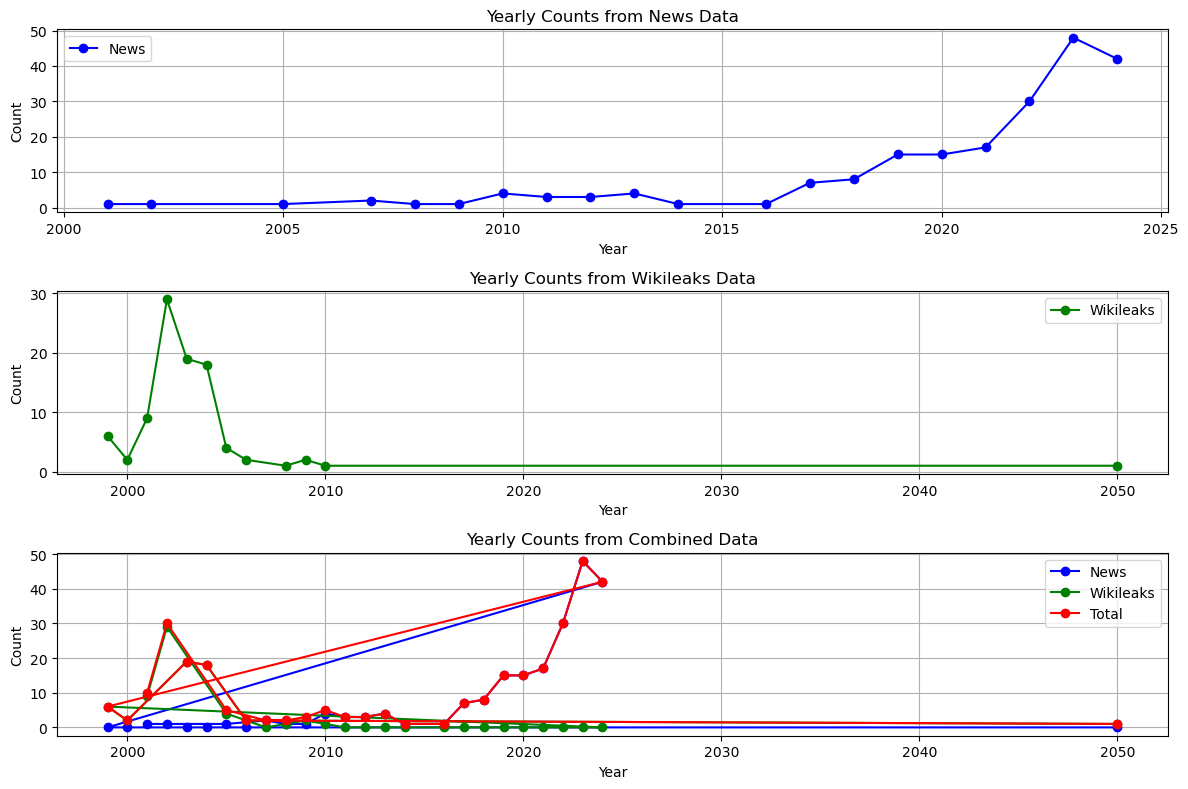

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Load the Excel files
news_file = './data/news_excerpts_parsed.xlsx'
wikileaks_file = './data/wikileaks_parsed.xlsx'

news_data = pd.read_excel(news_file)
wikileaks_data = pd.read_excel(wikileaks_file)

# Extract years from the news data
def extract_year_from_link(link):
    match = re.search(r'/20\d{2}|/19\d{2}', link)  # Match only valid years (1900-2099)
    if match:
        return int(match.group(0)[1:])  # Remove the leading '/' and return the year
    return None

news_data['Year'] = news_data['Link'].apply(extract_year_from_link)
news_data = news_data.dropna(subset=['Year'])  # Remove rows without a year

# Extract years from the wikileaks data
def extract_year_from_text(text):
    match = re.search(r'\b(19\d{2}|20\d{2})\b', text)  # Match valid years (1900-2099)
    return int(match.group(0)) if match else None

wikileaks_data['Year'] = wikileaks_data['Text'].apply(extract_year_from_text)
wikileaks_data = wikileaks_data.dropna(subset=['Year'])  # Remove rows without a year

# Count occurrences by year
news_yearly_counts = news_data['Year'].value_counts().sort_index()
wikileaks_yearly_counts = wikileaks_data['Year'].value_counts().sort_index()

# Combine both datasets for a unified view
combined_yearly_counts = (
    pd.concat([
        news_yearly_counts.rename('News'),
        wikileaks_yearly_counts.rename('Wikileaks')
    ], axis=1)
    .fillna(0)
)
combined_yearly_counts['Total'] = combined_yearly_counts.sum(axis=1)

# Plot the time series
plt.figure(figsize=(12, 8))

# News data
plt.subplot(3, 1, 1)
plt.plot(news_yearly_counts.index, news_yearly_counts.values, marker='o', label='News', color='blue')
plt.title('Yearly Counts from News Data')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.legend()

# Wikileaks data
plt.subplot(3, 1, 2)
plt.plot(wikileaks_yearly_counts.index, wikileaks_yearly_counts.values, marker='o', label='Wikileaks', color='green')
plt.title('Yearly Counts from Wikileaks Data')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.legend()

# Combined data
plt.subplot(3, 1, 3)
plt.plot(combined_yearly_counts.index, combined_yearly_counts['News'], marker='o', label='News', color='blue')
plt.plot(combined_yearly_counts.index, combined_yearly_counts['Wikileaks'], marker='o', label='Wikileaks', color='green')
plt.plot(combined_yearly_counts.index, combined_yearly_counts['Total'], marker='o', label='Total', color='red')
plt.title('Yearly Counts from Combined Data')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Insights:
- News Data Dynamics: The increasing trend in news articles suggests a growing volume of news coverage over time. This could be attributed to factors like the rise of digital media, increased news consumption, and the growth of online news sources
- Wikileaks Activity Pattern: The trend of Wikileaks releases suggests that their activity is likely influenced by various factors, such as the availability of information, internal decisions, and external events. The initial increase could be due to increase usage of media and thus information sources. The decline in activity after an initial period could be due to various reasons, such as resource constraints, changes in strategy, or increased scrutiny